In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:
img = cv2.imread('images/pitch-lines.png')
img = img[:,:,::-1] #changes BGR to RGB

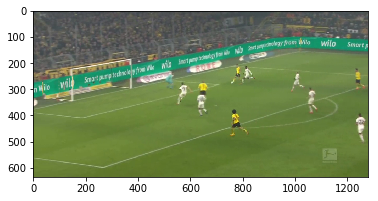

In [3]:
plt.imshow(img)

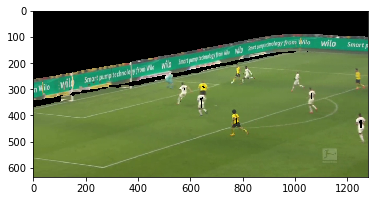

In [4]:
#dilation of green hues to select the pitch+surroundings, eliminating the crowd
sensitivity = 25

min_filter = np.array([60 - sensitivity, 100, 100])
max_filter = np.array([60 + sensitivity, 255, 255])

mask = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), min_filter, max_filter)

kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(mask,kernel,iterations = 5)
res = cv2.bitwise_and(img,img, mask=dilation)

plt.imshow(res)

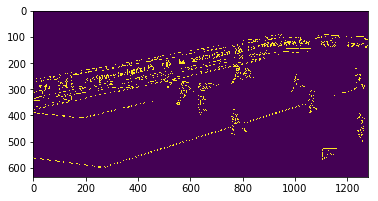

In [5]:
v = np.median(res)
sigma=0.33

lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edge = cv2.Canny(res, lower, upper)

plt.imshow(edge)

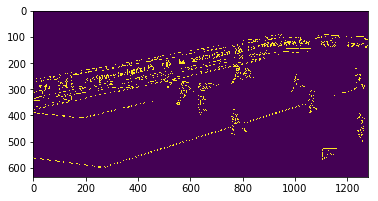

In [6]:
ret,final_img = cv2.threshold(edge,20,255,cv2.THRESH_BINARY)

plt.imshow(final_img)

In [7]:
minLineLength = 90
maxLineGap = 10

lines = cv2.HoughLinesP(final_img,1,1*np.pi/180,50,minLineLength=minLineLength,maxLineGap=maxLineGap)
lines = lines[:,0,:]
print(lines.shape)

lines[:5]

(72, 4)


array([[  22,  371,  430,  284],
       [ 200,  267,  463,  216],
       [ 557,  197,  750,  163],
       [ 556,  193,  750,  156],
       [ 827,  424, 1049,  356]], dtype=int32)

The output of ``HoughLinesP`` is an array of line segments as ``[x1, y1, x2, y2]``. In this case, we found 81 lines. 
Let's plot them:

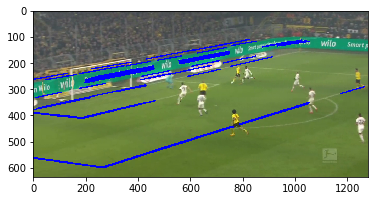

In [8]:
img_copy = img.copy()
for x1,y1,x2,y2 in lines:
    cv2.line(img_copy,(x1,y1),(x2,y2),(0,0,255),4)

plt.imshow(img_copy)

A lot of lines overlap. One way to merge them is to convert the lines to slope/intercept format. Overlapping or continuous lines will have similar slope and intercept parameters.

In [9]:
def get_slope_intercept(x1, y1, x2, y2):
    point1 = (x1,y1)
    point2 = (x2,y2)
    slope = (point2[1]-point1[1]) / (point2[0]-point1[0])
    intercept = point2[1]-slope*point2[0]
    if slope!=-np.inf:
        return slope, intercept
    else:
        return 0,0

si = [get_slope_intercept(*line) for line in lines]
slopes, intercepts = zip(*si)

(array([11.,  1.,  0.,  4.,  7., 24., 18.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  3.,  2.]),
 array([-0.32110092, -0.29806474, -0.27502856, -0.25199238, -0.22895621,
        -0.20592003, -0.18288385, -0.15984767, -0.13681149, -0.11377532,
        -0.09073914, -0.06770296, -0.04466678, -0.0216306 ,  0.00140557,
         0.02444175,  0.04747793,  0.07051411,  0.09355029,  0.11658646,
         0.13962264]),
 <a list of 20 Patch objects>)

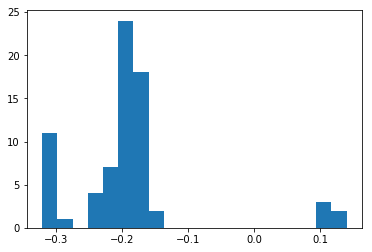

In [10]:
plt.hist(slopes, bins=20)

(array([12., 10., 15.,  4.,  4.,  5.,  3.,  0.,  1.,  4.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  1., 11.]),
 array([258.64516129, 280.01382066, 301.38248002, 322.75113939,
        344.11979876, 365.48845812, 386.85711749, 408.22577686,
        429.59443622, 450.96309559, 472.33175496, 493.70041432,
        515.06907369, 536.43773306, 557.80639242, 579.17505179,
        600.54371116, 621.91237052, 643.28102989, 664.64968926,
        686.01834862]),
 <a list of 20 Patch objects>)

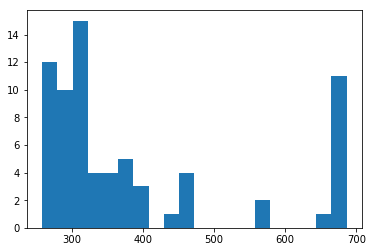

In [11]:
plt.hist(intercepts, bins=20)

In [12]:
import networkx
from scipy.spatial.distance import pdist, squareform

def reduce_lines(lines, std=0.15):
    try:
        dist = squareform(pdist(lines, 'seuclidean'))
        pair_to_merge = [(a,b) for a,b in zip(*np.where(dist<std)) if a<b]
    except:
        print(lines, len(lines))

    g = networkx.Graph()
    for edge in pair_to_merge:
        g.add_edge(*edge)

    merges = list(networkx.connected_components(g))

    lines = np.array(lines)
    merged = [np.mean(lines[list(merge)], axis=0) for merge in merges]
    try:
        unmerged = lines[list(set(range(lines.shape[0]))-set(g.nodes()))]
        merged = np.vstack([*merged, unmerged])
    except AttributeError:
        pass

    return merged

reduced_lines = reduce_lines(si)

reduced_lines.shape

(7, 2)

In [13]:
def get_line_coords_from_si(slope, intercept):
    max_x = img.shape[1]
    max_y = int(intercept + max_x*slope)
    intercept = int(intercept)
    return (0,intercept, max_x, max_y)

line_coords = [get_line_coords_from_si(*si) for si in reduced_lines]

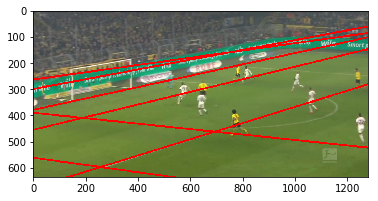

In [14]:
img_copy = img.copy()

for x1,y1,x2,y2 in line_coords:
    img = cv2.line(img_copy,(x1,y1),(x2,y2),(255,0,0),5)

plt.imshow(img_copy)